# First exploration of a patents dump

In [1]:
import pandas as pd
from langdetect import detect as detect_language

We used method `detect_language` imported above to enable keeping only english abstracts. Results were saved because it was heavy calculation

In [7]:
data = pd.read_csv("../data/patents2016_epo_with_language.csv", sep=",", 
                   index_col=0,
                   names=["id", "abstract", "language"])[1:]

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data = data.set_index("id")

In [22]:
data.head()

,abstract,language
id,,
448476353,La présente invention se rapporte à un procédé...,fr
448078788,The invention relates to a circuit assembly (1...,en
448476383,We describe apparatus for controlling the filt...,en
448078784,Minimally-invasive spinal inventions are often...,en
448476384,The present disclosure relates to nucleic acid...,en


## Keeping only english abstracts

In [10]:
print("There are ", len(data[data.language == "en"]), " english abstracts")

There are  37013  english abstracts


We decide to choose randomly `N_RANDOM` of them

In [11]:
N_RANDOM = 10000

Let's select them

In [12]:
import random
a = range(len(data[data.language == "en"]))
b = random.sample(a, N_RANDOM)

In [13]:
data_en = data[data.language == "en"].iloc[b]

In [14]:
print("Our data is now of length ", len(data_en))

Our data is now of length  10000


## (don't run) NLP Pre processing

In [16]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import stop_words
import string
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet

def get_wordnet_tag(treebank_tag):
    """ enables to map pos tags from treebank to wordnet valid pos tags 
    (in order to feed the lemmatizer) """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:  # if starts with N or others (noun by default)
        return wordnet.NOUN
    
def lemmatize(token):
    """ final method to lemmatize using wordnet lemmatizer """
    
    trbk_tag = pos_tag([token])[0][1]  # get the treebank tag from pos_tag method
    wrdnt_tag = get_wordnet_tag(treebank_tag=trbk_tag)  # translate it to wordnet tag
    return lemmatizer.lemmatize(token, wrdnt_tag)

stop_words_ = stop_words.get_stop_words("en")
punctuation_filter = str.maketrans({key: None for key in string.punctuation})

def nlp_pre_process(text, lemma=False, stem=False):
    """
    Reduces an input text into a list of tokens, 
    using NLP filterings such as normalization, 
    PoS and stop word filtering, stemming.
    text: (str)
    tokens: list(str)
    """
    text = text.lower()  # normalize
    text = text.translate(punctuation_filter)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    pos_tags = [pos_tag([t]) for t in tokens]  # PoS tagging
    tokens = [token for [(token, tag)] in pos_tags if tag != "DT"]  # PoS filtering
    tokens = [t for t in tokens if t not in stop_words_]  # stop words filtering
    
    if stem:
        tokens = [stemmer.stem(t) for t in tokens]  # stemming
    
    if lemma:
        tokens = [lemmatize(t) for t in tokens]  # lemmatizing
    
    return " ".join(tokens)

In [162]:
#data_en.abstract = data_en.abstract.apply(nlp_pre_process)

In [18]:
data_en = pd.read_csv("../data/patents2016_preprocessed.csv")

In [19]:
data_en.abstract.head()

0    systems methods provided reliable wireless gro...
1    provided method preparing new type recombinant...
2    accordance certain embodiments patterns formed...
3    shatter proof enclosure mount motion capture e...
4    present disclosure relates process apparatus p...
Name: abstract, dtype: object

Our english data is ready

# -------------- TOPIC EXTRACTION --------------

## If problem with textmining package : http://stackoverflow.com/questions/15717752/python3-3-importerror-with-textmining-1-0

In [23]:
%matplotlib inline
from textmining import TermDocumentMatrix
import numpy as np
import lda
from sklearn.manifold import TSNE
import seaborn as sns
import logging
import json
logging.getLogger("lda").setLevel(logging.WARNING)  # disable INFOs output from lda

Term Document Matrix

In [65]:
# ranges of documents.
ranges = {}
tdm = TermDocumentMatrix(tokenizer=lambda s: s.split(" "))
titles = []
count = 0
nlp_processed = data_en.abstract.values

for abstract in nlp_processed:
    abstract = abstract.split()
    titles.append(abstract[:40])
    tdm.add_doc(" ".join(abstract))

(10011, 11)

In [66]:
count = 0
term_frequency_matrix = []
for row in tdm.rows(cutoff=1):
    if count == 0:
        vocab = row
        count += 1
    else:
        term_frequency_matrix.append(row)
term_frequency_matrix = np.array(term_frequency_matrix)

In [69]:
term_frequency_matrix.shape

(10000, 30538)

In [26]:
N_TOPICS = 11
lda = lda.LDA(n_topics=N_TOPICS, n_iter=1500, random_state=1)
lda.fit(term_frequency_matrix)

In [27]:
X = lda.doc_topic_
X = np.concatenate((X, np.identity(N_TOPICS)), axis=0)  # add centroids

In [28]:
N_TOP_WORDS = 30
topic_word = lda.topic_word_
centroid_labels = []
for topic, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-N_TOP_WORDS:-1]
    centroid_label = ", ".join(topic_words[0:16])
    centroid_labels.append(centroid_label)

array([[  1.90416780e-07,   1.90416780e-07,   1.90416780e-07, ...,
          3.81023978e-04,   1.90416780e-07,   1.90416780e-07],
       [  2.22225284e-07,   2.22225284e-07,   2.22225284e-07, ...,
          2.22225284e-07,   2.22225284e-07,   2.22225284e-07],
       [  1.99122348e-07,   1.99122348e-07,   1.99122348e-07, ...,
          1.99122348e-07,   1.99122348e-07,   1.99122348e-07],
       ..., 
       [  8.70058372e-05,   2.89055938e-07,   2.89055938e-07, ...,
          2.89055938e-07,   2.89055938e-07,   2.89055938e-07],
       [  1.02125873e-07,   1.02125873e-07,   1.02125873e-07, ...,
          1.02125873e-07,   1.02125873e-07,   1.02125873e-07],
       [  1.61505542e-07,   8.09142764e-05,   1.61505542e-07, ...,
          1.61505542e-07,   1.61505542e-07,   1.61505542e-07]])

In [70]:
import pyLDAvis

In [76]:
term_frequency_matrix.shape

(10000, 30538)

In [78]:
frequencies = np.sum(term_frequency_matrix, axis=0)

In [84]:
np.array(lda.doc_topic_).T.shape

(11, 10000)

In [85]:
np.array([len(t.split()) for t in nlp_processed]).shape

(10000,)

In [89]:
frequencies[0]

8

In [91]:
model_data = { "topic_term_dists": np.array(lda.topic_word_),
         "doc_topic_dists": np.array(lda.doc_topic_),
         "doc_lengths": np.array([len(t.split()) for t in nlp_processed]),
         "vocab": vocab,
         "term_frequency": frequencies}

In [90]:
(np.array(lda.doc_topic_).T * np.array([len(t.split()) for t in nlp_processed])).T.sum()

672132.0

In [96]:
viz = pyLDAvis.prepare(**model_data)

In [97]:
pyLDAvis.display(viz)

# -------------- DIMENSION REDUCTION --------------

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

 Fisher Linear Discriminant could be interesting see slide 29 http://www.cs.cmu.edu/~guestrin/Class/10701-S05/slides/dimensionality.pdf

### Try to supervise colors of communities given related subject

In [32]:
n_top_words = 12
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: data method information network communication wireless one device transmission plurality signal block
Topic 1: invention methods present comprising compositions relates treatment also cells provides treating thereof
Topic 2: image light unit display optical device lens includes position object one configured
Topic 3: layer substrate surface semiconductor electrode region material formed includes structure film device
Topic 4: fluid said flow 1 chamber 2 gas air one 10 device least
Topic 5: method composition invention least material group one present comprising compound wherein c
Topic 6: may can methods system include systems andor used embodiments devices present using
Topic 7: member end portion body surface includes assembly one side position outer support
Topic 8: first second portion includes element third least one direction wherein plurality part
Topic 9: data device user one information system method content based least associated computer
Topic 10: power signal contr

blue : looks like IT , electrical engineering abstracts (topics 0, 9, 10)  
orange : looks like physics (topics 2, 8, 4)  
yellow : chemistry, biology, materials (topics 1, 3, 7)  
gray : trash topics (5,6,8)  

In [36]:
current_palette = ["blue", "yellow", "orange", "yellow", "orange", "gray", "gray", "yellow", "gray", "blue", "blue"]

In [34]:
def visualize_fischer_lda():
    
    # define fischer_lda
    #http://stackoverflow.com/questions/23277958/how-to-run-and-interpret-fishers-linear-discriminant-analysis-from-scikit-learn
    from sklearn.lda import LDA as fischerLDA
    fischerLDA = fischerLDA(n_components=2)

    # y must be the assignments. Suppose we say it is the topic that has maximum value in the distribution
    y = list(np.argmax(X, axis=1))
    X_fischerLDA = fischerLDA.fit_transform(X, y)
    
    # define colors
    colors = [current_palette[c] for c in y]
    
    # define bounds 
    a = X.shape[0] - N_TOPICS
    b = X.shape[0]
    
    # plot the abstracts projection
    plt.figure(figsize=(15,15))
    for i in range(len(data_en)):
        plt.scatter(X_fischerLDA[i,0], X_fischerLDA[i,1], c=colors[i])

    # plot the topic centroids
    plt.scatter(X_fischerLDA[a:b,0], X_fischerLDA[a:b,1], c=current_palette, marker="p", 
                linewidths=20, edgecolors="r", alpha=.8)

    # doing the legend
    import matplotlib.patches as mpatches
    patches = []
    for i,c in enumerate(current_palette):
        patches.append(mpatches.Patch(color=c, label=centroid_labels[i]))
    plt.legend(handles=patches, loc=3)
    
    plt.show()

/Users/arnaudmiribel/anaconda/envs/ada/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


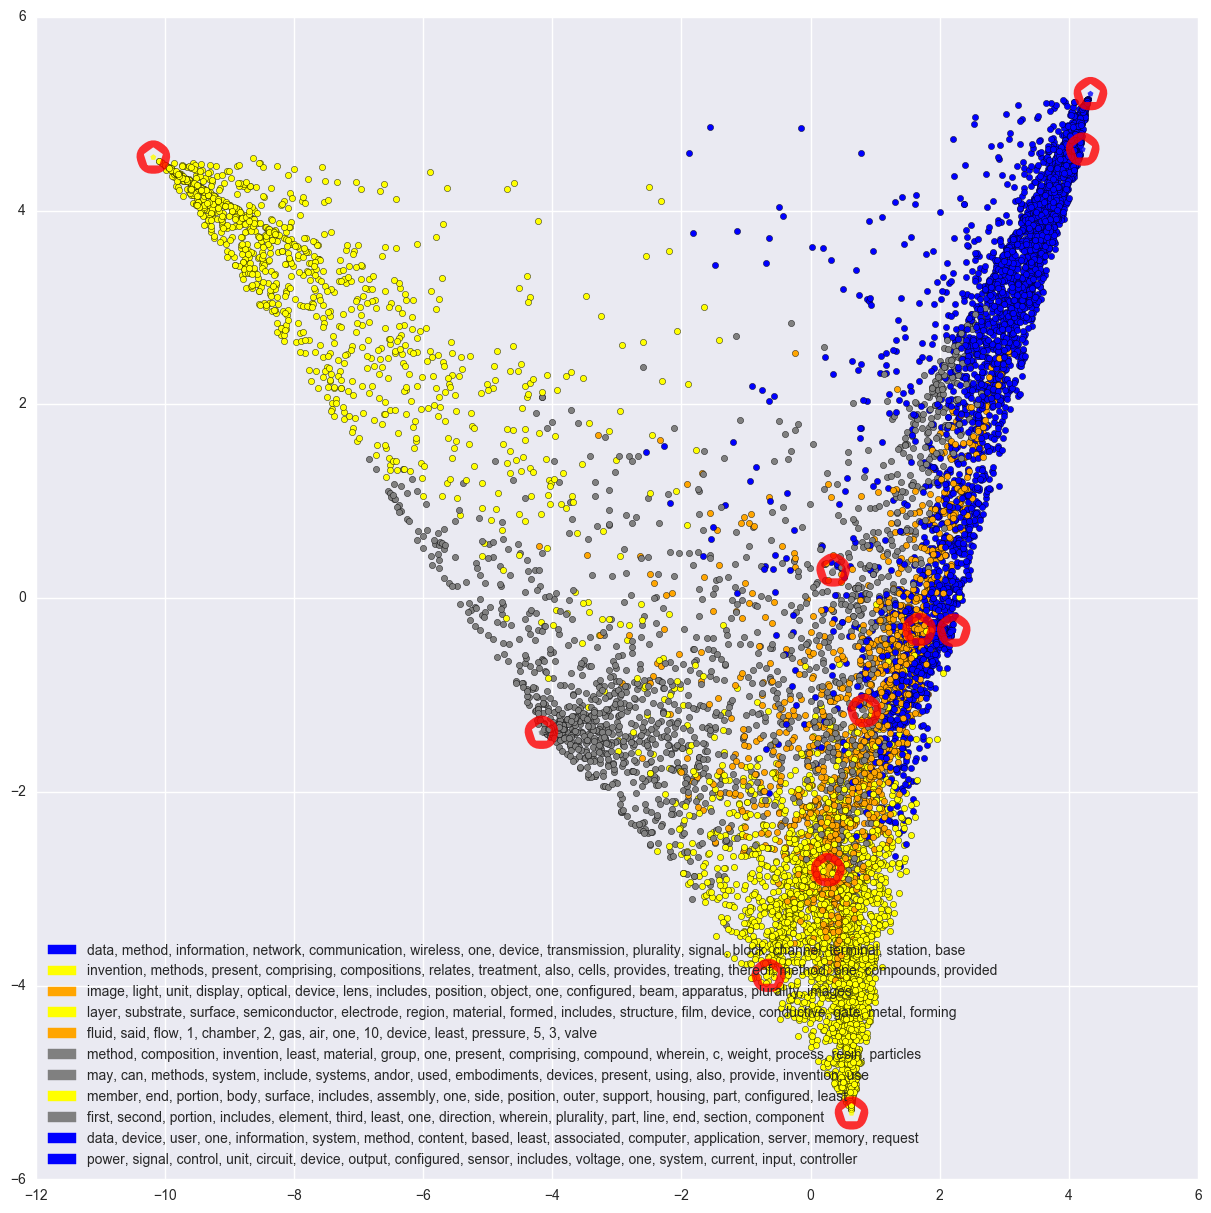

In [37]:
visualize_fischer_lda()

# Try to guess classes

In [38]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    distance_list = []
    num_cluster, _ = mu.shape
    for k_th in range(num_cluster):
        sum_squares = np.sum(np.square(data - mu[k_th, :]), axis=1)
        distance_list.append(sum_squares)
    return np.array(distance_list).T

In [39]:
def visualize_tsne():
    
    # reduce dimension using TSNE
    X_tsne = TSNE(learning_rate=100).fit_transform(X)
    
    # define bounds 
    a = X.shape[0] - N_TOPICS
    b = X.shape[0]
    
    # infer assignments (1 execution of k-means with centroids)
    distance_matrix = build_distance_matrix(X_tsne[0:len(data_en),:], X_tsne[a:b,:])
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)
    
    # define colors
    colors = [current_palette[a] for a in assignments]
    
    # scatter points
    plt.figure(figsize=(15,15))
    for i in range(len(data_en)):
        plt.scatter(X_tsne[i,0], X_tsne[i,1], c=colors[i])


    plt.scatter(X_tsne[a:b,0], X_tsne[a:b,1], c=current_palette, marker="p", 
                linewidths=20, edgecolors="r", alpha=.8)

    # doing the legend
    import matplotlib.patches as mpatches
    patches = []
    for i,c in enumerate(current_palette):
        patches.append(mpatches.Patch(color=c, label=centroid_labels[i]))
    plt.legend(handles=patches)
    plt.show()


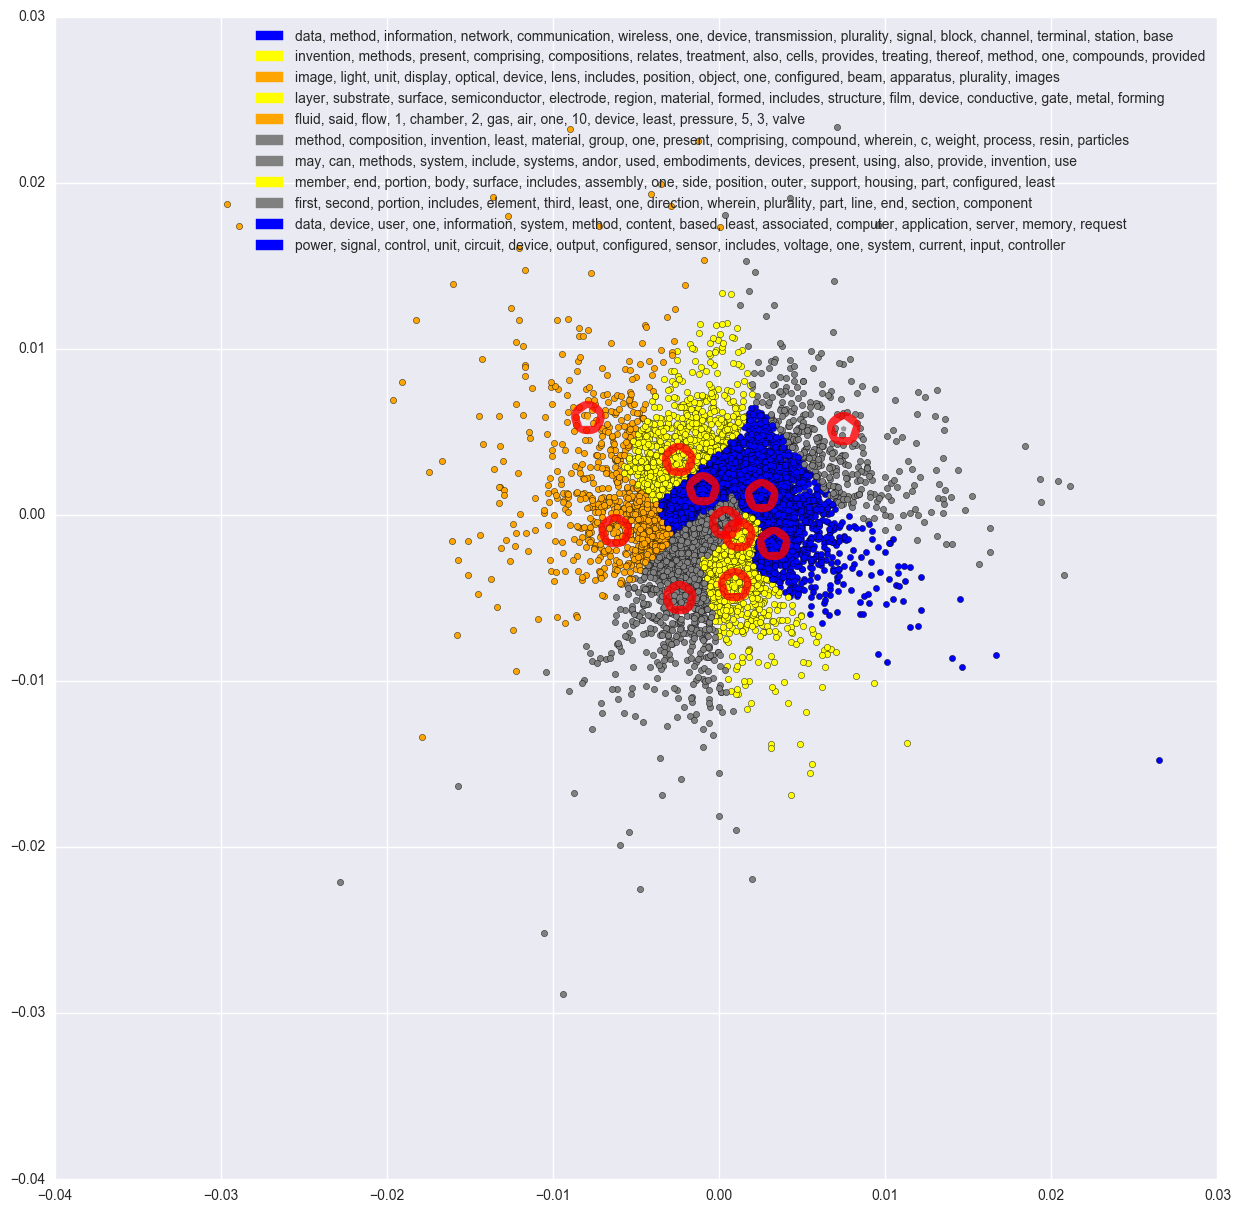

In [40]:
visualize_tsne()

In [53]:
def visualize_pca():
    
    # reduce dimension using TSNE
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    #X_pca = PCA(learning_rate=100).fit_transform(X)
    
    # define bounds 
    a = X.shape[0] - N_TOPICS
    b = X.shape[0]
    
    # infer assignments (1 execution of k-means with centroids)
    distance_matrix = build_distance_matrix(X_pca[0:len(data_en),:], X_pca[a:b,:])
    losses = np.min(distance_matrix, axis=1)
    assignments = np.argmin(distance_matrix, axis=1)
    
    # define colors
    colors = [current_palette[a] for a in assignments]
    
    # scatter points
    plt.figure(figsize=(15,15))
    for i in range(len(data_en)):
        plt.scatter(X_pca[i,0], X_pca[i,1], c=colors[i])


    plt.scatter(X_pca[a:b,0], X_pca[a:b,1], c=current_palette, marker="p", 
                linewidths=20, edgecolors="r", alpha=.8)

    # doing the legend
    import matplotlib.patches as mpatches
    patches = []
    for i,c in enumerate(current_palette):
        patches.append(mpatches.Patch(color=c, label=centroid_labels[i]))
    plt.legend(handles=patches)
    plt.show()


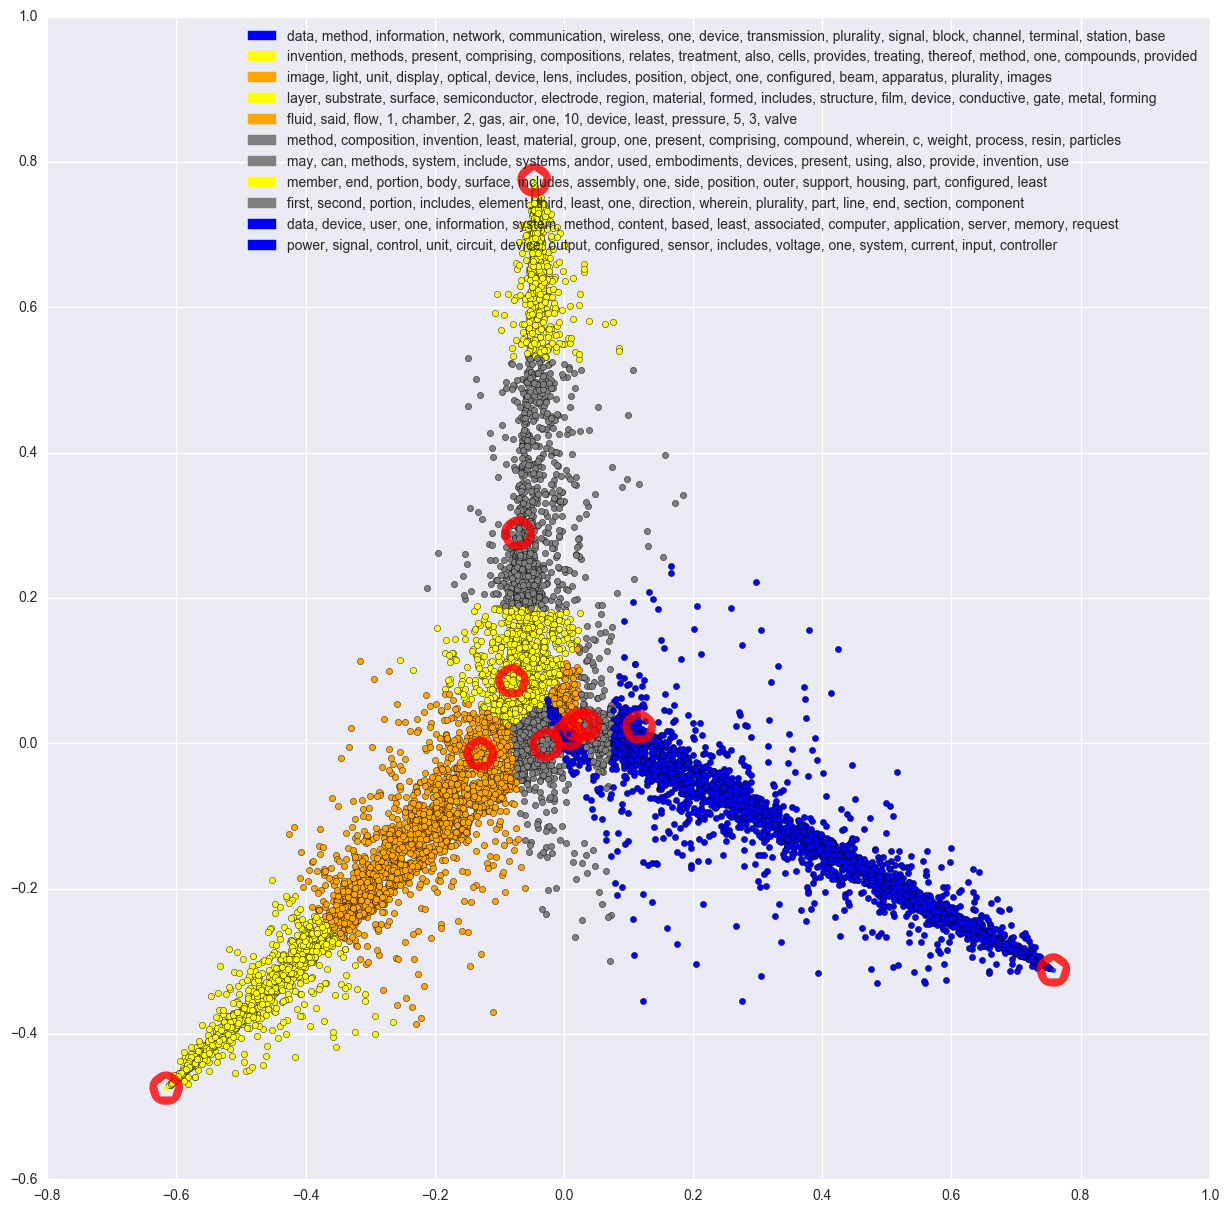

In [54]:
visualize_pca()

# Bokeh trials

In [18]:
output_notebook()

Loading BokehJS ...

In [96]:
p.plot_height=800
p.plot_width=800
p.title.text = "What are the topics U.S Presidency candidates talk about ?"
p.title.text_font_size = "20pt"
# Turn off tick labels
p.axis.major_label_text_font_size = '0pt'  
# Turn off tick marks 
p.axis.major_tick_line_color = None  # turn off major ticks
p.axis[0].ticker.num_minor_ticks = 0  # turn off minor ticks
p.axis[1].ticker.num_minor_ticks = 0

# remove grids
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#legend
p.legend.orientation = "vertical"
p.legend.location = "bottom_right"
p.legend.background_fill_alpha = 1
p.legend.label_text_font = "Avenir"

show(p)

TypeError: 'NoneType' object is not iterable

In [68]:
from bokeh.embed import file_html
from bokeh.resources import CDN

html = file_html(p, CDN, "US Candidates topics")
with open("plot_US.html", "w") as f:
    f.write(html)

TypeError: 'NoneType' object is not iterable

In [17]:
bokeh.io.reset_output() # ultra important not to overcrowd the export
output_notebook(bokeh.resources.INLINE)  # enable bokeh to run inline in Jupyter
TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select,poly_select, hover, undo, redo"

# Create figure

p = figure(tools=TOOLS,plot_width=600, plot_height=300)

# Scatter data from politicians
source = ColumnDataSource(
                data = dict(
                        x=X_tsne[:,0], 
                        y=X_tsne[:,1],
                        qualifier=["Abstract"]*X_tsne.shape[0],
                        content=titles.append(centroid_labels))
                )

p.scatter('x', 'y', source=source, color="black")

# Scatter topics

a = X.shape[0] - N_TOPICS
b = X.shape[0]

source = ColumnDataSource(data=dict(
    x = X_tsne[a:b,0],
    y = X_tsne[a:b,1],
    qualifier=["Topic"]*(b-a),
    content = centroid_labels
    ))

p.scatter('x', 'y', source=source, color="red", marker="diamond", size=30, legend="Topic")
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Type", "@qualifier"),
    ("Content", "@content")
]

Loading BokehJS ...

In [16]:
titles = [" ".join(t) for t in titles]